In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import math

In [2]:
numCellsX, numCellsY = 1000, 1000
gridXLength = gridYLength = 1.0
cellXLength = gridXLength / numCellsX
cellYLength = gridYLength / numCellsY
gravity = 1.0
layerDepth = 1.0
fastestSignalSpeed = math.sqrt(gravity * layerDepth)
height = np.full((numCellsY, numCellsX), layerDepth)
xVelocity = np.zeros((numCellsY, numCellsX))
yVelocity = np.zeros((numCellsY, numCellsX))
bumpAltitude = 0.1
bumpWidth = 0.1 * gridXLength
bumpCenterX, bumpCenterY = 0.7, 0.3
bottomTopography = np.zeros((numCellsY, numCellsX))
coriolis = np.zeros((numCellsY, numCellsX))
CFL = 0.4
maxSpeed = np.maximum(np.abs(xVelocity) + fastestSignalSpeed, np.abs(yVelocity) + fastestSignalSpeed).max()
dt = CFL * min(cellXLength, cellYLength) / maxSpeed
dt0 = CFL * min(cellXLength, cellYLength) / fastestSignalSpeed
nSteps = 2000
outputEvery = 25
startingMass = height.sum()
averageNeighborMultiple = 0.001
hu = height * xVelocity
hv = height * yVelocity

In [3]:
x = np.linspace(0, gridXLength, numCellsX)
y = np.linspace(0, gridYLength, numCellsY)
X, Y = np.meshgrid(x, y, indexing="xy")
numerator = (X - bumpCenterX)**2 + (Y - bumpCenterY)**2
denominator = 2 * bumpWidth**2
height = layerDepth + bumpAltitude * np.exp(-numerator**2/denominator)
height

array([[1.        , 1.00000001, 1.00000001, ..., 1.02021951, 1.02000425,
        1.01978987],
       [1.00000001, 1.00000001, 1.00000001, ..., 1.02043708, 1.02022023,
        1.02000425],
       [1.00000001, 1.00000001, 1.00000001, ..., 1.02065552, 1.02043708,
        1.02021951],
       ...,
       [1.        , 1.        , 1.        , ..., 1.00000001, 1.00000001,
        1.00000001],
       [1.        , 1.        , 1.        , ..., 1.00000001, 1.00000001,
        1.00000001],
       [1.        , 1.        , 1.        , ..., 1.00000001, 1.00000001,
        1.        ]])

In [4]:
# # how many leftmost columns to set
# n_cols = 15  # tweak as you like

# # base field
# height = np.full((numCellsY, numCellsX), layerDepth)

# # column-wise sine: col 0 -> sin(0), col 1 -> sin(1), ...
# cols = np.arange(n_cols)
# col_vals = np.sin(cols)                      # shape (n_cols,)

# # add (or set) a perturbation for the first n_cols
# height[:, :n_cols] = layerDepth + bumpAltitude * col_vals  # broadcasts over rows

# # (optional) keep depth positive
# height = np.clip(height, 1e-6, None)


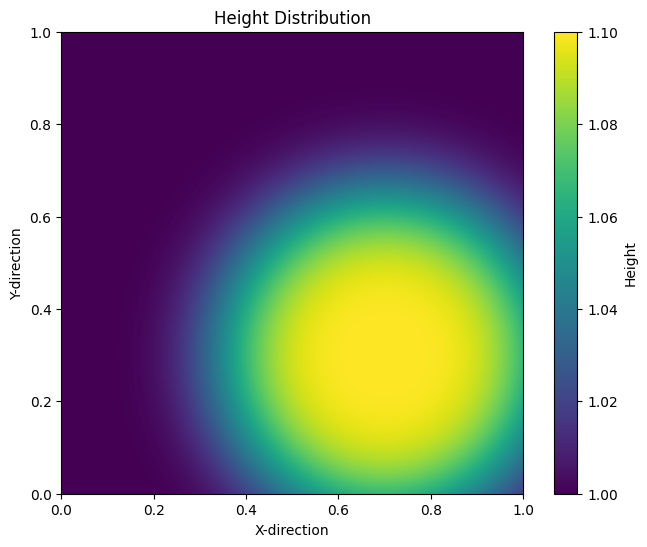

In [5]:
def plotHeight():
    plt.figure(figsize=(8, 6))
    plt.imshow(height, extent=[0, gridXLength, 0, gridYLength], origin='lower', cmap='viridis')
    plt.colorbar(label='Height')
    plt.title('Height Distribution')
    plt.xlabel('X-direction')
    plt.ylabel('Y-direction')
    plt.show()
plotHeight()

/usr/local/lib/python3.12/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.12/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


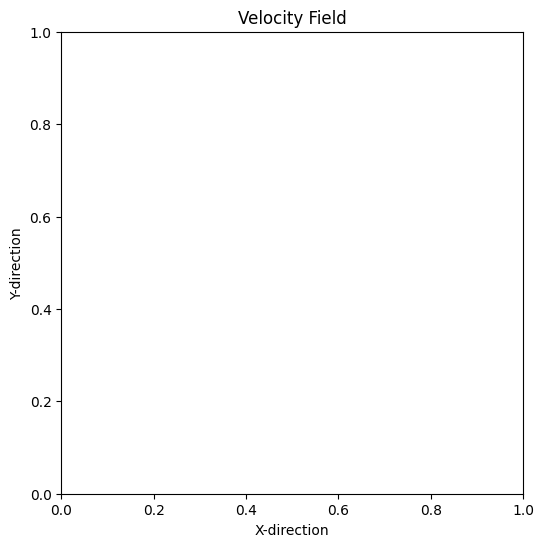

In [6]:
def plotVelocityField(xVelocity, yVelocity, gridXLength, gridYLength, stride=5):
    """
    xVelocity, yVelocity: 2D arrays [ny, nx]
    gridXLength, gridYLength: physical size of domain
    stride: sample every Nth vector so it's not a solid block of arrows
    """

    ny, nx = xVelocity.shape

    # coordinates of cell centers
    x = np.linspace(0.5 * gridXLength / nx, gridXLength - 0.5 * gridXLength / nx, nx)
    y = np.linspace(0.5 * gridYLength / ny, gridYLength - 0.5 * gridYLength / ny, ny)
    X, Y = np.meshgrid(x, y)

    # take every `stride`-th arrow so the plot is readable
    Xs = X[::stride, ::stride]
    Ys = Y[::stride, ::stride]
    U  = xVelocity[::stride, ::stride]
    V  = yVelocity[::stride, ::stride]

    # speed magnitude
    speed = np.sqrt(U**2 + V**2)

    # we want arrow *length* to reflect speed. quiver does this naturally if we
    # use scale_units='xy' and a fixed scale. smaller scale => longer arrows.
    plt.figure(figsize=(8,6))
    q = plt.quiver(
        Xs, Ys,          # positions
        U, V,            # vector components
        angles='xy',
        scale_units='xy',
        scale=None,      # None => no automatic rescale; raw vector length = arrow length
        pivot='mid',     # arrow centered on the grid cell
        width=0.002      # thin arrows so they don't look like blobs
    )

    # optional: add a reference arrow so you know what length means
    # pick a spot (like bottom left) and draw one arrow with known speed
    ref_speed = np.max(speed)
    if ref_speed > 0:
        plt.quiverkey(
            q,
            X=0.1, Y=1.05, U=ref_speed,
            label=f"{ref_speed:.3f} m/s",
            labelpos='E',
            coordinates='axes'
        )

    plt.xlim(0, gridXLength)
    plt.ylim(0, gridYLength)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Velocity Field')
    plt.xlabel('X-direction')
    plt.ylabel('Y-direction')
    plt.show()
plotVelocityField(xVelocity, yVelocity, gridXLength, gridYLength)

In [7]:
def roll_left(a):  return np.roll(a, -1, axis=1)   # i -> i+1
def roll_right(a): return np.roll(a,  1, axis=1)   # i -> i-1
def roll_up(a):    return np.roll(a, -1, axis=0)   # j -> j+1
def roll_down(a):  return np.roll(a,  1, axis=0)   # j -> j-1

def laplacian(field):
    return (roll_left(field) + roll_right(field) + roll_up(field) + roll_down(field) - 4.0*field)

def rusanov_flux_x(hL, uL, vL, hR, uR, vR, g):
    # conserved states
    huL, hvL = hL*uL, hL*vL
    huR, hvR = hR*uR, hR*vR
    # physical flux F(U) in x
    FL_h  = huL
    FL_hu = huL*uL + 0.5*g*hL*hL
    FL_hv = huL*vL

    FR_h  = huR
    FR_hu = huR*uR + 0.5*g*hR*hR
    FR_hv = huR*vR

    # everything above is basically the same as what i implemented

    # even with x velocity as 0, height differences can still cause movement
    # thats what cL and cR are. how much height difference on faces and adding that to the actual momentum
    cL = np.sqrt(g*hL); cR = np.sqrt(g*hR)
    smax = np.maximum(np.abs(uL)+cL, np.abs(uR)+cR)

    # avg of left and right then skew upwind by second term scaled by speed
    Fh  = 0.5*(FL_h  + FR_h ) - 0.5*smax*(hR  - hL)
    Fhu = 0.5*(FL_hu + FR_hu) - 0.5*smax*(huR - huL)
    Fhv = 0.5*(FL_hv + FR_hv) - 0.5*smax*(hvR - hvL)
    return Fh, Fhu, Fhv

def rusanov_flux_y(hB, uB, vB, hT, uT, vT, g):
    # conserved states
    huB, hvB = hB*uB, hB*vB
    huT, hvT = hT*uT, hT*vT
    # physical flux G(U) in y
    GL_h  = hvB
    GL_hu = huB*vB
    GL_hv = hvB*vB + 0.5*g*hB*hB

    GR_h  = hvT
    GR_hu = huT*vT
    GR_hv = hvT*vT + 0.5*g*hT*hT

    cB = np.sqrt(g*hB); cT = np.sqrt(g*hT)
    smax = np.maximum(np.abs(vB)+cB, np.abs(vT)+cT)

    Gh  = 0.5*(GL_h  + GR_h ) - 0.5*smax*(hT  - hB)
    Ghu = 0.5*(GL_hu + GR_hu) - 0.5*smax*(huT - huB)
    Ghv = 0.5*(GL_hv + GR_hv) - 0.5*smax*(hvT - hvB)
    return Gh, Ghu, Ghv

def compute_rhs(h, u, v, dx, dy, g, nu=0.0, h_eps=1e-12):
    # compute faces according to rusanov method
    # Left/Right states at vertical faces (i+1/2): current cell is "L", rolled-left is "R"
    hL, hR = h,  roll_left(h)
    uL, uR = u,  roll_left(u)
    vL, vR = v,  roll_left(v)
    Fh, Fhu, Fhv = rusanov_flux_x(hL,uL,vL, hR,uR,vR, g)

    # Bottom/Top states at horizontal faces (j+1/2): current cell is "B", rolled-up is "T"
    hB, hT = h,  roll_up(h)
    uB, uT = u,  roll_up(u)
    vB, vT = v,  roll_up(v)
    Gh, Ghu, Ghv = rusanov_flux_y(hB,uB,vB, hT,uT,vT, g)

    # find derivative given cell i and cell i-1 for each grid cell
    # Flux divergences (periodic): (F_{i+1/2} - F_{i-1/2})/dx, same for y
    dFh_dx  = (Fh  - roll_right(Fh )) / dx
    dFhu_dx = (Fhu - roll_right(Fhu)) / dx
    dFhv_dx = (Fhv - roll_right(Fhv)) / dx

    dGh_dy  = (Gh  - roll_down(Gh )) / dy
    dGhu_dy = (Ghu - roll_down(Ghu)) / dy
    dGhv_dy = (Ghv - roll_down(Ghv)) / dy

    # Conserved variables
    hu = h*u
    hv = h*v

    # sum up derivatives to get total change in cell. add up total change in height from faces, total change in u and v.
    # RHS for conserved vars
    rh_h  = -(dFh_dx  + dGh_dy)
    rh_hu = -(dFhu_dx + dGhu_dy)
    rh_hv = -(dFhv_dx + dGhv_dy)

    if nu != 0.0:
        rh_h  += nu * laplacian(h)
        rh_hu += nu * laplacian(hu)
        rh_hv += nu * laplacian(hv)

    return rh_h, rh_hu, rh_hv

In [8]:
def step(h, u, v, dt, dx, dy, g=1.0, nu=0.0, h_eps=1e-12):
    """
    One TVD-RK2 step for 2D shallow water with Rusanov (LLF) fluxes.
    Inputs/outputs:
        h,u,v : arrays on cell centers
        dt    : time step already chosen to satisfy 2D CFL
        dx,dy : grid spacings
        g     : gravity (default 1.0)
        nu    : optional small Laplacian viscosity on conserved vars
    """
    # with current height,x,y compute the derivatives of stuff. then with h1,hu1,hv1 compute step t+dt with current derivatives
    # ---- Stage 1
    rh_h, rh_hu, rh_hv = compute_rhs(h, u, v, dx, dy, g, nu, h_eps)
    h1  = h  + dt * rh_h
    hu1 = h*u + dt * rh_hu
    hv1 = h*v + dt * rh_hv

    # positivity clamp before forming u1,v1
    h1  = np.maximum(h1, h_eps)
    u1  = hu1 / h1
    v1  = hv1 / h1

    # take the predicted t+dt step with h1,u1,v1 and find the derivatives of those states.
    # ---- Stage 2 (Heun)
    rh_h2, rh_hu2, rh_hv2 = compute_rhs(h1, u1, v1, dx, dy, g, nu, h_eps)

    # given the derivatives of h,u,v at t and t+dt, average the change between those timesteps and add it to h
    # this expression is a simplified version of h + 0.5 * (change at t + change at t+dt)
    # RK2 step states that since we take discrete time steps at t, the slope of change is x, but at t+dt the slope of change is y.
    # since it's continuous we can better estimate the real slope of change between t and t+dt as (x+y)/2 = the average of the change
    h2  = 0.5*(h  + h1  + dt*rh_h2)
    hu2 = 0.5*(h*u + hu1 + dt*rh_hu2)
    hv2 = 0.5*(h*v + hv1 + dt*rh_hv2)

    # final positivity & return primitives
    h2 = np.maximum(h2, h_eps)
    u2 = hu2 / h2
    v2 = hv2 / h2
    return h2, u2, v2

Step: 0


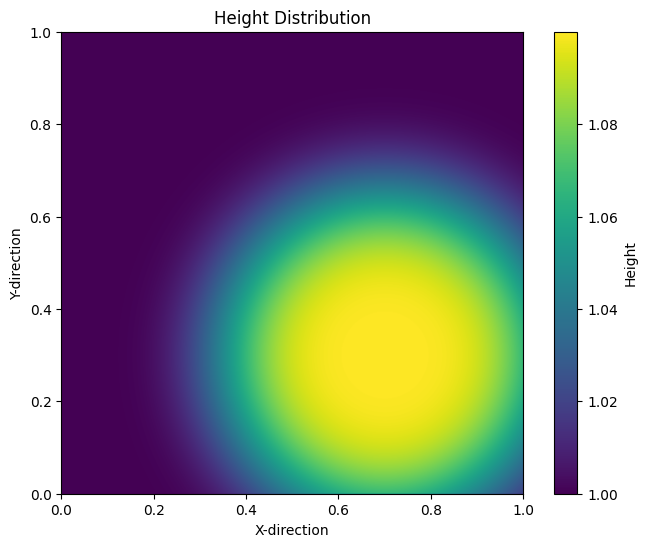

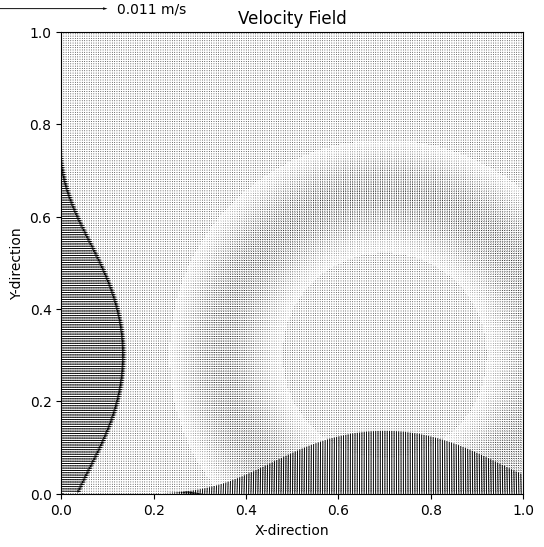

Step: 25


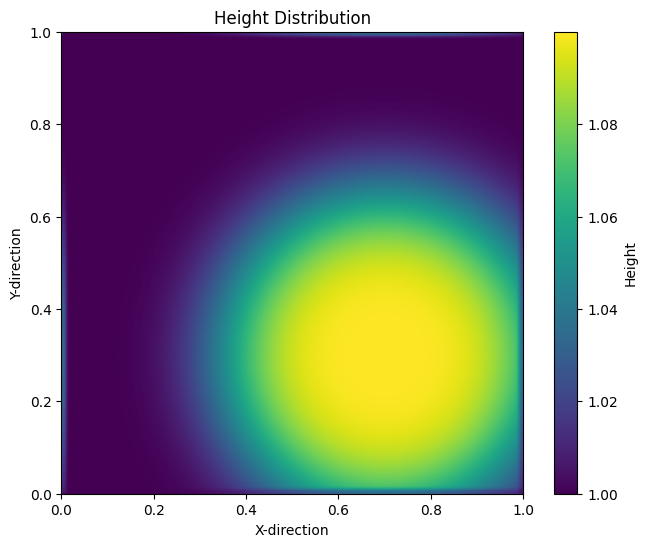

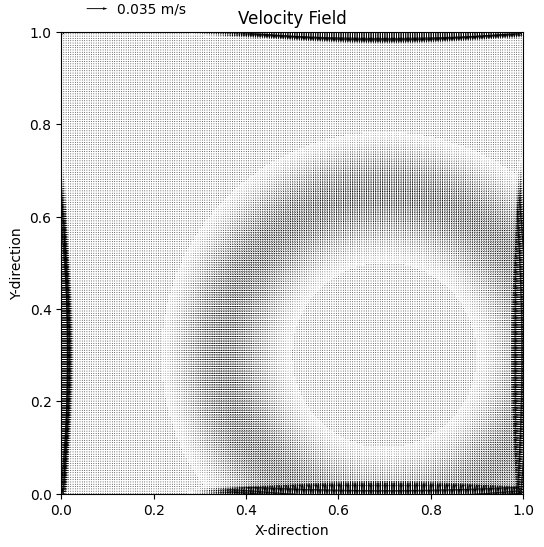

KeyboardInterrupt: 

In [23]:
# for i in range(nSteps):
#     # localWaveSpeed = np.sqrt(gravity * height)
#     # maxSignal = np.maximum(np.abs(xVelocity) + localWaveSpeed, np.abs(yVelocity) + localWaveSpeed).max()
#     # dt = CFL * min(cellXLength, cellYLength) / maxSignal

#     height, xVelocity, yVelocity = step(height, xVelocity, yVelocity, dt0, cellXLength, cellYLength)

#     if i % outputEvery == 0:
#         print(f"Step: {i}")
#         plotHeight()
#         plotVelocityField(xVelocity, yVelocity, gridXLength, gridYLength)

In [22]:
import numpy as np
from numba import njit

@njit(inline='always')
def idx_left(i, nx):
    return i-1 if i > 0 else nx-1

@njit(inline='always')
def idx_right(i, nx):
    return i+1 if i < nx-1 else 0

@njit(inline='always')
def idx_down(j, ny):
    return j-1 if j > 0 else ny-1

@njit(inline='always')
def idx_up(j, ny):
    return j+1 if j < ny-1 else 0

# # @njit
# def compute_rhs_numba(h, u, v, dx, dy, g, nu, h_eps):
#     ny, nx = h.shape

#     rh_h  = np.zeros_like(h)
#     rh_hu = np.zeros_like(h)
#     rh_hv = np.zeros_like(h)

#     # main flux divergence
#     for j in range(ny):
#         for i in range(nx):
#             # neighbors
#             ir = idx_right(i, nx)
#             il = idx_left(i, nx)
#             ju = idx_up(j, ny)
#             jd = idx_down(j, ny)

#             # ----- X faces -----
#             # right face between (j,i) [L] and (j,ir) [R]
#             hL = h[j, i]
#             uL = u[j, i]
#             vL = v[j, i]

#             hR = h[j, ir]
#             uR = u[j, ir]
#             vR = v[j, ir]

#             huL = hL * uL
#             hvL = hL * vL
#             huR = hR * uR
#             hvR = hR * vR

#             # physical flux F(U) in x
#             FL_h  = huL
#             FL_hu = huL*uL + 0.5*g*hL*hL
#             FL_hv = huL*vL

#             FR_h  = huR
#             FR_hu = huR*uR + 0.5*g*hR*hR
#             FR_hv = huR*vR

#             cL = np.sqrt(g*hL)
#             cR = np.sqrt(g*hR)
#             smax_x = max(abs(uL)+cL, abs(uR)+cR)

#             Fh_right  = 0.5*(FL_h  + FR_h ) - 0.5*smax_x*(hR  - hL)
#             Fhu_right = 0.5*(FL_hu + FR_hu) - 0.5*smax_x*(huR - huL)
#             Fhv_right = 0.5*(FL_hv + FR_hv) - 0.5*smax_x*(hvR - hvL)

#             # left face between (j,il) [L] and (j,i) [R]
#             hL2 = h[j, il]
#             uL2 = u[j, il]
#             vL2 = v[j, il]

#             hR2 = hL
#             uR2 = uL
#             vR2 = vL

#             huL2 = hL2 * uL2
#             hvL2 = hL2 * vL2
#             huR2 = hR2 * uR2
#             hvR2 = hR2 * vR2

#             FL_h2  = huL2
#             FL_hu2 = huL2*uL2 + 0.5*g*hL2*hL2
#             FL_hv2 = huL2*vL2

#             FR_h2  = huR2
#             FR_hu2 = huR2*uR2 + 0.5*g*hR2*hR2
#             FR_hv2 = huR2*vR2

#             cL2 = np.sqrt(g*hL2)
#             cR2 = np.sqrt(g*hR2)
#             smax_x2 = max(abs(uL2)+cL2, abs(uR2)+cR2)

#             Fh_left  = 0.5*(FL_h2  + FR_h2 ) - 0.5*smax_x2*(hR2  - hL2)
#             Fhu_left = 0.5*(FL_hu2 + FR_hu2) - 0.5*smax_x2*(huR2 - huL2)
#             Fhv_left = 0.5*(FL_hv2 + FR_hv2) - 0.5*smax_x2*(hvR2 - hvL2)

#             dFh_dx  = (Fh_right  - Fh_left ) / dx
#             dFhu_dx = (Fhu_right - Fhu_left) / dx
#             dFhv_dx = (Fhv_right - Fhv_left) / dx

#             # ----- Y faces -----
#             # up face between (j,i) [B] and (ju,i) [T]
#             hB = h[j, i]
#             uB = u[j, i]
#             vB = v[j, i]

#             hT = h[ju, i]
#             uT = u[ju, i]
#             vT = v[ju, i]

#             huB = hB * uB
#             hvB = hB * vB
#             huT = hT * uT
#             hvT = hT * vT

#             GL_h  = hvB
#             GL_hu = huB*vB
#             GL_hv = hvB*vB + 0.5*g*hB*hB

#             GR_h  = hvT
#             GR_hu = huT*vT
#             GR_hv = hvT*vT + 0.5*g*hT*hT

#             cB = np.sqrt(g*hB)
#             cT = np.sqrt(g*hT)
#             smax_y = max(abs(vB)+cB, abs(vT)+cT)

#             Gh_up  = 0.5*(GL_h  + GR_h ) - 0.5*smax_y*(hT  - hB)
#             Ghu_up = 0.5*(GL_hu + GR_hu) - 0.5*smax_y*(huT - huB)
#             Ghv_up = 0.5*(GL_hv + GR_hv) - 0.5*smax_y*(hvT - hvB)

#             # down face between (jd,i) [B] and (j,i) [T]
#             hB2 = h[jd, i]
#             uB2 = u[jd, i]
#             vB2 = v[jd, i]

#             hT2 = hB
#             uT2 = uB
#             vT2 = vB

#             huB2 = hB2 * uB2
#             hvB2 = hB2 * vB2
#             huT2 = hT2 * uT2
#             hvT2 = hT2 * vT2

#             GL_h2  = hvB2
#             GL_hu2 = huB2*vB2
#             GL_hv2 = hvB2*vB2 + 0.5*g*hB2*hB2

#             GR_h2  = hvT2
#             GR_hu2 = huT2*vT2
#             GR_hv2 = hvT2*vT2 + 0.5*g*hT2*hT2

#             cB2 = np.sqrt(g*hB2)
#             cT2 = np.sqrt(g*hT2)
#             smax_y2 = max(abs(vB2)+cB2, abs(vT2)+cT2)

#             Gh_down  = 0.5*(GL_h2  + GR_h2 ) - 0.5*smax_y2*(hT2  - hB2)
#             Ghu_down = 0.5*(GL_hu2 + GR_hu2) - 0.5*smax_y2*(huT2 - huB2)
#             Ghv_down = 0.5*(GL_hv2 + GR_hv2) - 0.5*smax_y2*(hvT2 - hvB2)

#             dGh_dy  = (Gh_up  - Gh_down ) / dy
#             dGhu_dy = (Ghu_up - Ghu_down) / dy
#             dGhv_dy = (Ghv_up - Ghv_down) / dy

#             # RHS = -(div F + div G)
#             rh_h[j,i]  = -(dFh_dx  + dGh_dy)
#             rh_hu[j,i] = -(dFhu_dx + dGhu_dy)
#             rh_hv[j,i] = -(dFhv_dx + dGhv_dy)

#     # optional Laplacian viscosity
#     if nu != 0.0:
#         for j in range(ny):
#             for i in range(nx):
#                 ir = idx_right(i, nx)
#                 il = idx_left(i, nx)
#                 ju = idx_up(j, ny)
#                 jd = idx_down(j, ny)

#                 lap_h  = (h[j,ir]  + h[j,il]  + h[ju,i]  + h[jd,i]  - 4.0*h[j,i])
#                 hu_ij  = h[j,i]*u[j,i]
#                 hv_ij  = h[j,i]*v[j,i]
#                 hu_ir  = h[j,ir]*u[j,ir]
#                 hu_il  = h[j,il]*u[j,il]
#                 hu_ju  = h[ju,i]*u[ju,i]
#                 hu_jd  = h[jd,i]*u[jd,i]
#                 lap_hu = (hu_ir + hu_il + hu_ju + hu_jd - 4.0*hu_ij)
#                 hv_ir  = h[j,ir]*v[j,ir]
#                 hv_il  = h[j,il]*v[j,il]
#                 hv_ju  = h[ju,i]*v[ju,i]
#                 hv_jd  = h[jd,i]*v[jd,i]
#                 lap_hv = (hv_ir + hv_il + hv_ju + hv_jd - 4.0*hv_ij)

#                 rh_h[j,i]  += nu * lap_h
#                 rh_hu[j,i] += nu * lap_hu
#                 rh_hv[j,i] += nu * lap_hv

#     return rh_h, rh_hu, rh_hv
# # @njit
# def step_numba(h, u, v, dt, dx, dy, bc_mode=0, g=1.0, nu=0.0, h_eps=1e-12):
#     rh_h, rh_hu, rh_hv = compute_rhs_numba(h, u, v, dx, dy, g, nu, h_eps)

#     ny, nx = h.shape
#     h1  = np.empty_like(h)
#     u1  = np.empty_like(u)
#     v1  = np.empty_like(v)
#     hu1 = np.empty_like(h)  # store h1*u1
#     hv1 = np.empty_like(h)

#     # stage 1 (Euler)
#     for j in range(ny):
#         for i in range(nx):
#             hu = h[j,i]*u[j,i]
#             hv = h[j,i]*v[j,i]

#             h_pred  = h[j,i]  + dt * rh_h[j,i]
#             hu_pred = hu       + dt * rh_hu[j,i]
#             hv_pred = hv       + dt * rh_hv[j,i]

#             if h_pred < h_eps:
#                 h_pred = h_eps

#             h1[j,i]  = h_pred
#             u1[j,i]  = hu_pred / h_pred
#             v1[j,i]  = hv_pred / h_pred
#             hu1[j,i] = hu_pred
#             hv1[j,i] = hv_pred

#     # stage 2
#     rh_h2, rh_hu2, rh_hv2 = compute_rhs_numba(h1, u1, v1, dx, dy, g, nu, h_eps)

#     h2  = np.empty_like(h)
#     u2  = np.empty_like(u)
#     v2  = np.empty_like(v)

#     for j in range(ny):
#         for i in range(nx):
#             hu0 = h[j,i]*u[j,i]
#             hv0 = h[j,i]*v[j,i]

#             h_final  = 0.5*( h[j,i]  + h1[j,i]  + dt*rh_h2[j,i] )
#             hu_final = 0.5*( hu0     + hu1[j,i] + dt*rh_hu2[j,i] )
#             hv_final = 0.5*( hv0     + hv1[j,i] + dt*rh_hv2[j,i] )

#             if h_final < h_eps:
#                 h_final = h_eps

#             h2[j,i] = h_final
#             u2[j,i] = hu_final / h_final
#             v2[j,i] = hv_final / h_final

#     return h2, u2, v2

In [10]:
# for i in range(nSteps):
#     height, xVelocity, yVelocity = step_numba(height, xVelocity, yVelocity, dt0, cellXLength, cellYLength)

#     if i % outputEvery == 0:
#         print(f"Step: {i}")
#         plotHeight()
#         plotVelocityField(xVelocity, yVelocity, gridXLength, gridYLength)

In [23]:
import numpy as np
from numba import njit

# bc_mode: 0=periodic, 1=reflective, 2=open
@njit
def apply_bc_numba(h, u, v, nx, ny, bc_mode):
    # LEFT / RIGHT boundaries (i = 0 and i = nx+1)
    for j in range(1, ny+1):
        if bc_mode == 0:  # periodic
            h[j, 0]      = h[j, nx]
            u[j, 0]      = u[j, nx]
            v[j, 0]      = v[j, nx]
            h[j, nx+1]   = h[j, 1]
            u[j, nx+1]   = u[j, 1]
            v[j, nx+1]   = v[j, 1]

        elif bc_mode == 1:  # reflective wall in x-normal direction
            # mirror depth
            h[j, 0]      = h[j, 1]
            h[j, nx+1]   = h[j, nx]
            # normal component u flips sign
            u[j, 0]      = -u[j, 1]
            u[j, nx+1]   = -u[j, nx]
            # tangential component v copies
            v[j, 0]      =  v[j, 1]
            v[j, nx+1]   =  v[j, nx]

        else:  # bc_mode == 2, open / zero-gradient
            h[j, 0]      = h[j, 1]
            u[j, 0]      = u[j, 1]
            v[j, 0]      = v[j, 1]
            h[j, nx+1]   = h[j, nx]
            u[j, nx+1]   = u[j, nx]
            v[j, nx+1]   = v[j, nx]

    # BOTTOM / TOP boundaries (j = 0 and j = ny+1)
    for i in range(1, nx+1):
        if bc_mode == 0:  # periodic
            h[0, i]      = h[ny, i]
            u[0, i]      = u[ny, i]
            v[0, i]      = v[ny, i]
            h[ny+1, i]   = h[1, i]
            u[ny+1, i]   = u[1, i]
            v[ny+1, i]   = v[1, i]

        elif bc_mode == 1:  # reflective wall in y-normal direction
            # mirror depth
            h[0, i]      = h[1, i]
            h[ny+1, i]   = h[ny, i]
            # normal component v flips
            v[0, i]      = -v[1, i]
            v[ny+1, i]   = -v[ny, i]
            # tangential component u copies
            u[0, i]      =  u[1, i]
            u[ny+1, i]   =  u[ny, i]

        else:  # bc_mode == 2, open / zero-gradient
            h[0, i]      = h[1, i]
            u[0, i]      = u[1, i]
            v[0, i]      = v[1, i]
            h[ny+1, i]   = h[ny, i]
            u[ny+1, i]   = u[ny, i]
            v[ny+1, i]   = v[ny, i]

    # Corners: you can just do something consistent.
    # simplest: copy from nearest edge cell
    # (doesn't matter much for 1-layer SWE unless you're super picky)
    if bc_mode == 0:
        h[0,0]          = h[ny, nx]
        u[0,0]          = u[ny, nx]
        v[0,0]          = v[ny, nx]
        h[0,nx+1]       = h[ny,1]
        u[0,nx+1]       = u[ny,1]
        v[0,nx+1]       = v[ny,1]
        h[ny+1,0]       = h[1,nx]
        u[ny+1,0]       = u[1,nx]
        v[ny+1,0]       = v[1,nx]
        h[ny+1,nx+1]    = h[1,1]
        u[ny+1,nx+1]    = u[1,1]
        v[ny+1,nx+1]    = v[1,1]
    else:
        # copy from the adjacent interior corner
        h[0,0]          = h[1,1]
        u[0,0]          = u[1,1]
        v[0,0]          = v[1,1]
        h[0,nx+1]       = h[1,nx]
        u[0,nx+1]       = u[1,nx]
        v[0,nx+1]       = v[1,nx]
        h[ny+1,0]       = h[ny,1]
        u[ny+1,0]       = u[ny,1]
        v[ny+1,0]       = v[ny,1]
        h[ny+1,nx+1]    = h[ny,nx]
        u[ny+1,nx+1]    = u[ny,nx]
        v[ny+1,nx+1]    = v[ny,nx]

In [29]:
@njit
def compute_rhs_numba(h, u, v, dx, dy, g, nu, h_eps, nx, ny, b, coriolis):
    """
    h,u,v shape = (ny+2, nx+2)
    valid physical cells: j=1..ny, i=1..nx
    nx,ny are the interior sizes (no ghosts)
    returns rh_h, rh_hu, rh_hv with same shape
    ghost rows/cols in the RHS will stay 0
    """
    rh_h  = np.zeros_like(h)
    rh_hu = np.zeros_like(h)
    rh_hv = np.zeros_like(h)

    # main flux divergence
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            # neighbors in x
            il = i-1
            ir = i+1
            # neighbors in y
            jd = j-1
            ju = j+1

            # ------------ X faces ------------
            # right face between (j,i) [L] and (j,ir) [R]
            hL = h[j, i]
            uL = u[j, i]
            vL = v[j, i]

            hR = h[j, ir]
            uR = u[j, ir]
            vR = v[j, ir]

            huL = hL * uL
            hvL = hL * vL
            huR = hR * uR
            hvR = hR * vR

            # physical flux F(U) in x
            FL_h  = huL
            FL_hu = huL*uL + 0.5*g*hL*hL
            FL_hv = huL*vL

            FR_h  = huR
            FR_hu = huR*uR + 0.5*g*hR*hR
            FR_hv = huR*vR

            cL = np.sqrt(g*hL)
            cR = np.sqrt(g*hR)
            smax_x = max(abs(uL)+cL, abs(uR)+cR)

            Fh_right  = 0.5*(FL_h  + FR_h ) - 0.5*smax_x*(hR  - hL)
            Fhu_right = 0.5*(FL_hu + FR_hu) - 0.5*smax_x*(huR - huL)
            Fhv_right = 0.5*(FL_hv + FR_hv) - 0.5*smax_x*(hvR - hvL)

            # left face between (j,il) [L] and (j,i) [R]
            hL2 = h[j, il]
            uL2 = u[j, il]
            vL2 = v[j, il]

            hR2 = hL
            uR2 = uL
            vR2 = vL

            huL2 = hL2 * uL2
            hvL2 = hL2 * vL2
            huR2 = hR2 * uR2
            hvR2 = hR2 * vR2

            FL_h2  = huL2
            FL_hu2 = huL2*uL2 + 0.5*g*hL2*hL2
            FL_hv2 = huL2*vL2

            FR_h2  = huR2
            FR_hu2 = huR2*uR2 + 0.5*g*hR2*hR2
            FR_hv2 = huR2*vR2

            cL2 = np.sqrt(g*hL2)
            cR2 = np.sqrt(g*hR2)
            smax_x2 = max(abs(uL2)+cL2, abs(uR2)+cR2)

            Fh_left  = 0.5*(FL_h2  + FR_h2 ) - 0.5*smax_x2*(hR2  - hL2)
            Fhu_left = 0.5*(FL_hu2 + FR_hu2) - 0.5*smax_x2*(huR2 - huL2)
            Fhv_left = 0.5*(FL_hv2 + FR_hv2) - 0.5*smax_x2*(hvR2 - hvL2)

            dFh_dx  = (Fh_right  - Fh_left ) / dx
            dFhu_dx = (Fhu_right - Fhu_left) / dx
            dFhv_dx = (Fhv_right - Fhv_left) / dx

            # ------------ Y faces ------------
            # up face between (j,i) [B] and (ju,i) [T]
            hB = h[j, i]
            uB = u[j, i]
            vB = v[j, i]

            hT = h[ju, i]
            uT = u[ju, i]
            vT = v[ju, i]

            huB = hB * uB
            hvB = hB * vB
            huT = hT * uT
            hvT = hT * vT

            GL_h  = hvB
            GL_hu = huB*vB
            GL_hv = hvB*vB + 0.5*g*hB*hB

            GR_h  = hvT
            GR_hu = huT*vT
            GR_hv = hvT*vT + 0.5*g*hT*hT

            cB = np.sqrt(g*hB)
            cT = np.sqrt(g*hT)
            smax_y = max(abs(vB)+cB, abs(vT)+cT)

            Gh_up  = 0.5*(GL_h  + GR_h ) - 0.5*smax_y*(hT  - hB)
            Ghu_up = 0.5*(GL_hu + GR_hu) - 0.5*smax_y*(huT - huB)
            Ghv_up = 0.5*(GL_hv + GR_hv) - 0.5*smax_y*(hvT - hvB)

            # down face between (jd,i) [B] and (j,i) [T]
            hB2 = h[jd, i]
            uB2 = u[jd, i]
            vB2 = v[jd, i]

            hT2 = hB
            uT2 = uB
            vT2 = vB

            huB2 = hB2 * uB2
            hvB2 = hB2 * vB2
            huT2 = hT2 * uT2
            hvT2 = hT2 * vT2

            GL_h2  = hvB2
            GL_hu2 = huB2*vB2
            GL_hv2 = hvB2*vB2 + 0.5*g*hB2*hB2

            GR_h2  = hvT2
            GR_hu2 = huT2*vT2
            GR_hv2 = hvT2*vT2 + 0.5*g*hT2*hT2

            cB2 = np.sqrt(g*hB2)
            cT2 = np.sqrt(g*hT2)
            smax_y2 = max(abs(vB2)+cB2, abs(vT2)+cT2)

            Gh_down  = 0.5*(GL_h2  + GR_h2 ) - 0.5*smax_y2*(hT2  - hB2)
            Ghu_down = 0.5*(GL_hu2 + GR_hu2) - 0.5*smax_y2*(huT2 - huB2)
            Ghv_down = 0.5*(GL_hv2 + GR_hv2) - 0.5*smax_y2*(hvT2 - hvB2)

            dGh_dy  = (Gh_up  - Gh_down ) / dy
            dGhu_dy = (Ghu_up - Ghu_down) / dy
            dGhv_dy = (Ghv_up - Ghv_down) / dy

            # RHS = -(div F + div G)
            rh_h[j,i]  = -(dFh_dx  + dGh_dy)
            rh_hu[j,i] = -(dFhu_dx + dGhu_dy)
            rh_hv[j,i] = -(dFhv_dx + dGhv_dy)

            # --------- Coriolis source (conserved form) ---------
            # +f h v in x-momentum,  -f h u in y-momentum
            fij = coriolis[j,i]
            hij = h[j,i]
            rh_hu[j,i] +=  fij * hij * v[j,i]
            rh_hv[j,i] += -fij * hij * u[j,i]

    # --- bathymetry source term: -g * h * grad(b) ---
    for j in range(1, ny+1):
        jd = j-1
        ju = j+1
        for i in range(1, nx+1):
            il = i-1
            ir = i+1

            # centered slope of bottom
            dbdx = (b[j, ir] - b[j, il]) * 0.5 / dx
            dbdy = (b[ju, i] - b[jd, i]) * 0.5 / dy

            rh_hu[j,i] += -g * h[j,i] * dbdx
            rh_hv[j,i] += -g * h[j,i] * dbdy


    # optional Laplacian viscosity on conserved variables
    if nu != 0.0:
        for j in range(1, ny+1):
            jd = j-1
            ju = j+1
            for i in range(1, nx+1):
                il = i-1
                ir = i+1

                h_ij   = h[j,i]
                hu_ij  = h_ij * u[j,i]
                hv_ij  = h_ij * v[j,i]

                lap_h  = (h[j,ir]  + h[j,il]  + h[ju,i]  + h[jd,i]  - 4.0*h_ij)
                hu_ir  = h[j,ir]*u[j,ir]
                hu_il  = h[j,il]*u[j,il]
                hu_ju  = h[ju,i]*u[ju,i]
                hu_jd  = h[jd,i]*u[jd,i]
                lap_hu = (hu_ir + hu_il + hu_ju + hu_jd - 4.0*hu_ij)
                hv_ir  = h[j,ir]*v[j,ir]
                hv_il  = h[j,il]*v[j,il]
                hv_ju  = h[ju,i]*v[ju,i]
                hv_jd  = h[jd,i]*v[jd,i]
                lap_hv = (hv_ir + hv_il + hv_ju + hv_jd - 4.0*hv_ij)

                rh_h[j,i]  += nu * lap_h
                rh_hu[j,i] += nu * lap_hu
                rh_hv[j,i] += nu * lap_hv

    return rh_h, rh_hu, rh_hv

@njit
def step_numba(h, u, v, dt, dx, dy, b, coriolis,
               g=1.0, nu=0.0, h_eps=1e-12,
               nx=0, ny=0,
               bc_mode=0):
    # --- Stage 1 ---
    apply_bc_numba(h, u, v, nx, ny, bc_mode)

    rh_h, rh_hu, rh_hv = compute_rhs_numba(h, u, v, dx, dy, g, nu, h_eps, nx, ny, b, coriolis)

    h1  = np.empty_like(h)
    u1  = np.empty_like(u)
    v1  = np.empty_like(v)
    hu1 = np.empty_like(h)  # store h1*u1
    hv1 = np.empty_like(h)

    for j in range(1, ny+1):
        for i in range(1, nx+1):
            hu0 = h[j,i]*u[j,i]
            hv0 = h[j,i]*v[j,i]

            h_pred  = h[j,i]  + dt * rh_h[j,i]
            hu_pred = hu0     + dt * rh_hu[j,i]
            hv_pred = hv0     + dt * rh_hv[j,i]

            if h_pred < h_eps:
                h_pred = h_eps

            h1[j,i]  = h_pred
            u1[j,i]  = hu_pred / h_pred
            v1[j,i]  = hv_pred / h_pred
            hu1[j,i] = hu_pred
            hv1[j,i] = hv_pred

    # it's fine to leave ghost ring of h1/u1/v1 uninitialized for now,
    # because we're about to fill them with apply_bc_numba.
    # But to avoid numba "use of uninitialized" worries, we can copy h,u,v ghosts:
    # simplest: start by copying the whole arrays, then overwrite interior
    for j in range(ny+2):
        for i in range(nx+2):
            if j == 0 or j == ny+1 or i == 0 or i == nx+1:
                h1[j,i]  = h[j,i]
                u1[j,i]  = u[j,i]
                v1[j,i]  = v[j,i]
                hu1[j,i] = h[j,i]*u[j,i]
                hv1[j,i] = h[j,i]*v[j,i]

    # --- Stage 2 ---
    apply_bc_numba(h1, u1, v1, nx, ny, bc_mode)

    rh_h2, rh_hu2, rh_hv2 = compute_rhs_numba(h1, u1, v1, dx, dy, g, nu, h_eps, nx, ny, b, coriolis)

    h2 = np.empty_like(h)
    u2 = np.empty_like(u)
    v2 = np.empty_like(v)

    # We will again copy ghosts after computing interior
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            hu0 = h[j,i]*u[j,i]
            hv0 = h[j,i]*v[j,i]

            h_final  = 0.5*( h[j,i]  + h1[j,i]  + dt*rh_h2[j,i] )
            hu_final = 0.5*( hu0     + hu1[j,i] + dt*rh_hu2[j,i] )
            hv_final = 0.5*( hv0     + hv1[j,i] + dt*rh_hv2[j,i] )

            if h_final < h_eps:
                h_final = h_eps

            h2[j,i] = h_final
            u2[j,i] = hu_final / h_final
            v2[j,i] = hv_final / h_final

    # fill ghost ring of h2,u2,v2 by copying from h1 just to init memory
    for j in range(ny+2):
        for i in range(nx+2):
            if j == 0 or j == ny+1 or i == 0 or i == nx+1:
                h2[j,i] = h1[j,i]
                u2[j,i] = u1[j,i]
                v2[j,i] = v1[j,i]

    # Final BC so caller gets a "ready" field for next step
    apply_bc_numba(h2, u2, v2, nx, ny, bc_mode)

    return h2, u2, v2


In [187]:
import numpy as np
from numba import njit

def bc_mode_from_string(name: str) -> int:
    """
    Map human-readable boundary mode to int code for numba.

    0 = periodic wrap
    1 = reflective wall
    2 = open / zero-gradient
    """
    n = name.strip().lower()
    if n == "periodic":
        return 0
    elif n == "reflective":
        return 1
    elif n == "open" or n == "outflow" or n == "neumann":
        return 2
    else:
        # default or raise; raising is better so you notice
        raise ValueError(f"unknown bc mode {name!r}, expected 'periodic', 'reflective', or 'open'")

import numpy as np

def initializeWithRipple(numCellsX, numCellsY,
                         gridXLength, gridYLength,
                         layerDepth,
                         bumpAltitude,
                         bumpWidth,
                         bumpCenterX, bumpCenterY):
    """
    Returns h,u,v with ghost cells already allocated.
    Interior j=1..ny, i=1..nx is filled.
    Velocities start at 0.
    """
    nx = numCellsX
    ny = numCellsY

    # physical grid coordinates for cell centers
    x = np.linspace(0.0, gridXLength, nx)
    y = np.linspace(0.0, gridYLength, ny)
    X, Y = np.meshgrid(x, y, indexing="xy")

    # radial distance^2 from bump center
    numerator   = (X - bumpCenterX)**2 + (Y - bumpCenterY)**2
    denominator = 2.0 * (bumpWidth**2)

    # Gaussian mound on top of layerDepth
    interior_h = layerDepth + bumpAltitude * np.exp(-numerator / denominator)

    # allocate full arrays with ghost ring
    h_full = np.zeros((ny+2, nx+2), dtype=np.float64)
    u_full = np.zeros((ny+2, nx+2), dtype=np.float64)
    v_full = np.zeros((ny+2, nx+2), dtype=np.float64)

    # put interior_h into the interior region
    h_full[1:ny+1, 1:nx+1] = interior_h
    # u_full, v_full interior already 0

    return h_full, u_full, v_full

def initializeWithVortex(numCellsX, numCellsY,
                         gridXLength, gridYLength,
                         layerDepth,
                         x0, y0,
                         mode="solid",
                         Omega=4.0,          # used when mode="solid"  (rad/s in non-dim units)
                         Vmax=1.0, Rc=0.15,  # used when mode="rankine"
                         f=0.0, g=1.0,
                         balanced=False):
    """
    Returns h,u,v with ghost cells already allocated.
    Interior j=1..ny, i=1..nx is filled.

    mode="solid":     u = -Ω(y-y0), v = Ω(x-x0)
    mode="rankine":   uθ = Vmax * min(r/Rc, Rc/r), then convert to (u,v)

    balanced=True  -> sets a height anomaly η(r) so that
        dη/dr = (uθ^2/r + f uθ)/g  (gradient-wind balance)
      This greatly reduces initial gravity-wave transients.

    Units here are whatever your solver uses (often non-dimensional).
    """
    nx, ny = numCellsX, numCellsY
    f_int = f[1:ny+1, 1:nx+1]

    # cell-center coordinates
    x = np.linspace(0.0, gridXLength, nx)
    y = np.linspace(0.0, gridYLength, ny)
    X, Y = np.meshgrid(x, y, indexing="xy")

    dx = gridXLength / nx
    dy = gridYLength / ny

    # offsets & polar helpers
    xr = X - x0
    yr = Y - y0
    r = np.hypot(xr, yr)
    # avoid division by zero at center
    r_safe = np.where(r == 0.0, 1e-15, r)
    sinθ = np.where(r_safe > 0, yr / r_safe, 0.0)
    cosθ = np.where(r_safe > 0, xr / r_safe, 1.0)

    # tangential speed uθ(r)
    if mode == "solid":
        # solid-body: uθ = Ω r
        u_theta = Omega * r
    elif mode == "rankine":
        # piecewise: solid in core, 1/r outside
        u_theta = Vmax * np.minimum(r / Rc, Rc / np.maximum(r, 1e-15))
    else:
        raise ValueError("mode must be 'solid' or 'rankine'")

    # convert tangential to Cartesian (θ measured from +x axis CCW)
    # u = -uθ sinθ, v = +uθ cosθ
    u_interior = -u_theta * sinθ
    v_interior =  u_theta * cosθ

    # height field
    if balanced:
        # Numerically integrate dη/dr = (uθ^2/r + f uθ)/g along r, radially.
        # We do it by building a 1D profile vs r via binning, integrating, then mapping back.
        # Binning grid:
        r_max = np.hypot(gridXLength, gridYLength)
        nr = max(256, int(0.75 * (nx + ny)))  # decent radial resolution
        r_edges = np.linspace(0.0, r_max, nr + 1)
        r_cent = 0.5 * (r_edges[:-1] + r_edges[1:])

        # compute uθ and RHS on the full 2D, then bin-average onto r_cent
        utheta2_over_r = (u_theta**2) / np.maximum(r, 1e-15)
        rhs = (utheta2_over_r + f_int * u_theta) / g  # dη/dr

        # radial binning
        which = np.clip(np.digitize(r.ravel(), r_edges) - 1, 0, nr - 1)
        rhs_mean = np.bincount(which, weights=rhs.ravel(), minlength=nr)
        counts   = np.bincount(which, minlength=nr)
        rhs_mean = np.where(counts > 0, rhs_mean / np.maximum(counts, 1), 0.0)

        # integrate η(r) with trapezoid from 0
        drc = np.diff(r_cent, prepend=0.0)
        # use simple cumulative trapezoid: η_k ≈ Σ ( (rhs_k + rhs_{k-1})/2 * Δr )
        rhs_pad = np.concatenate([[rhs_mean[0]], rhs_mean])
        dr_pad  = np.concatenate([[r_cent[0]],   np.diff(r_cent)])
        eta_prof = np.cumsum(0.5 * (rhs_pad[1:] + rhs_pad[:-1]) * dr_pad)

        # map back η(r)
        eta_binned = eta_prof[which].reshape(r.shape)

        # remove mean anomaly to keep mass close to layerDepth
        eta_binned -= np.mean(eta_binned)

        interior_h = layerDepth + eta_binned
        # positivity floor if you run with small layerDepth
        interior_h = np.maximum(interior_h, 1e-8)
    else:
        # flat surface; the flow will adjust by emitting gravity waves
        interior_h = np.full((ny, nx), layerDepth, dtype=np.float64)

    # allocate with ghost ring
    h_full = np.zeros((ny + 2, nx + 2), dtype=np.float64)
    u_full = np.zeros((ny + 2, nx + 2), dtype=np.float64)
    v_full = np.zeros((ny + 2, nx + 2), dtype=np.float64)

    # place interior
    h_full[1:ny+1, 1:nx+1] = interior_h
    u_full[1:ny+1, 1:nx+1] = u_interior
    v_full[1:ny+1, 1:nx+1] = v_interior

    return h_full, u_full, v_full


@njit(fastmath=True)
def drive_left_boundary_height(height, xVelocity, yVelocity,
                               H0, waveAmp, waveFreq, t,
                               driveCols):
    """
    Impose a sinusoidal surface height at the left boundary columns [0:driveCols].

    height    : 2D array (ny, nx)
    xVelocity : 2D array (ny, nx)
    yVelocity : 2D array (ny, nx)
    H0        : base depth (e.g. 1.0)
    waveAmp   : wave amplitude (e.g. 0.02)
    waveFreq  : angular freq (rad/s)
    t         : current sim time
    driveCols : how many leftmost columns to overwrite (e.g. 3-5)

    returns nothing; modifies arrays in-place
    """
    ny, nx = height.shape
    target_h = H0 + waveAmp * np.sin(waveFreq * t)

    for j in range(ny):
        for i in range(driveCols):
            height[j, i] = target_h
            yVelocity[j, i] = 0.0  # optional: keep it 1D-ish

    # we do NOT force xVelocity here; let solver create it


# @njit(fastmath=True)
# def compute_dt(height, xVelocity, yVelocity,
#                gravity, CFL, dx, dy):
#     """
#     Compute a stable timestep from CFL for shallow water.
#     dt = CFL * min(dx,dy) / max(|u|+c, |v|+c)

#     Returns dt (scalar).
#     """
#     ny, nx = height.shape
#     maxSignal = 0.0

#     for j in range(ny):
#         for i in range(nx):
#             c = np.sqrt(gravity * height[j, i])
#             sigx = np.abs(xVelocity[j, i]) + c
#             sigy = np.abs(yVelocity[j, i]) + c
#             s = sigx if sigx > sigy else sigy
#             if s > maxSignal:
#                 maxSignal = s

#     # avoid divide-by-zero if domain is perfectly still
#     if maxSignal == 0.0:
#         return 1e9  # effectively "no restriction"

#     cell_min = dx if dx < dy else dy
#     return CFL * cell_min / maxSignal

from numba import njit
import numpy as np

@njit(fastmath=True)
def compute_dt(height, xVelocity, yVelocity,
               gravity, CFL, dx, dy,
               coriolis=None, nu=0.0):
    """
    Stable timestep for rotating shallow water (explicit):
      - Gravity-wave CFL: dt_cfl = CFL * min(dx,dy) / max(|u|+c, |v|+c)
      - Inertial (rotation) cap: dt_rot ≲ 0.9 / max(|f|)
      - Optional diffusion cap (if nu>0): dt_nu <= 0.25 * min(dx,dy)^2 / nu
    Arrays are assumed to have a 1-cell ghost ring; we scan interior only.
    """
    ny, nx = height.shape
    j0, j1 = 1, ny-1   # interior: [1..ny-2]
    i0, i1 = 1, nx-1

    # --- gravity-wave CFL ---
    maxSignal = 0.0
    for j in range(j0, j1):
        for i in range(i0, i1):
            c = np.sqrt(gravity * height[j, i])
            sx = abs(xVelocity[j, i]) + c
            sy = abs(yVelocity[j, i]) + c
            s  = sx if sx > sy else sy
            if s > maxSignal:
                maxSignal = s

    if maxSignal == 0.0:
        dt_cfl = 1e9
    else:
        cell_min = dx if dx < dy else dy
        dt_cfl = CFL * cell_min / maxSignal

    # --- rotation cap ---
    dt_rot = 1e9
    if coriolis is not None:
        fmax = 0.0
        for j in range(j0, j1):
            for i in range(i0, i1):
                fj = abs(coriolis[j, i])
                if fj > fmax:
                    fmax = fj
        if fmax > 0.0:
            dt_rot = 0.9 / fmax  # ~ < one inertial radian per step

    # --- diffusion cap (optional) ---
    dt_nu = 1e9
    if nu > 0.0:
        cell_min = dx if dx < dy else dy
        dt_nu = 0.25 * (cell_min * cell_min) / nu  # conservative 2D bound

    # return the most restrictive
    dt = dt_cfl if dt_cfl < dt_rot else dt_rot
    dt = dt if dt < dt_nu else dt_nu
    return dt



In [174]:
import matplotlib.pyplot as plt
import os

# make an output folder once
os.makedirs("frames", exist_ok=True)

def init_plot(height, gridXLength, gridYLength):
    # set up the figure only once
    fig, ax = plt.subplots(figsize=(8, 6))

    img = ax.imshow(
        height,
        extent=[0, gridXLength, 0, gridYLength],
        origin='lower',
        cmap='viridis',
        vmin=height.min(),
        vmax=height.max(),
        animated=False,
        interpolation='nearest',  # no smoothing = faster
    )

    cbar = fig.colorbar(img, ax=ax, label='Height')

    ax.set_xlabel('X-direction')
    ax.set_ylabel('Y-direction')

    plt.close(fig)

    return fig, ax, img, cbar

def saveHeightFrameFast(fig, ax, img, cbar, height, frame_idx):
    # update image data in-place
    img.set_data(height)

    # OPTIONAL: if dynamic range changes a lot, update vmin/vmax.
    # If your wave heights don't change massively, skip these two lines for speed.
    img.set_clim(vmin=height.min(), vmax=height.max())

    # update colorbar to match new clim
    cbar.update_normal(img)

    ax.set_title(f'Height Distribution (frame {frame_idx})')

    fig.savefig(f"frames/frame_{frame_idx:05d}.png", dpi=150)

def make_bathymetry(nx, ny):
    """
    Create a static bottomTopography / bathymetry field b with ghost cells.
    Shape will be (ny+2, nx+2) to match your h,u,v arrays.

    We place 3 circular mounds (like seamounts) along a vertical column,
    all centered at the same x position, at ~25%, ~50%, ~75% of the domain in y.

    Returns:
        b : np.ndarray of shape (ny+2, nx+2)
    """

    # ------------------------
    # tunable parameters
    # ------------------------

    # physical domain size in "meters" or whatever units you're using
    Lx = 1.0
    Ly = 1.0

    # where (in x) the column of mounds sits, as a fraction of domain width
    mound_x_frac = 0.4 # 0 = left edge, 1 = right edge

    # y positions of the 3 mounds (fractions of domain height)
    mound_y_fracs = np.array([0.25, 0.50, 0.75])

    # mound peak height (how tall the bump in the ground is)
    mound_height = 0.5  # increase = taller seamount

    # mound "radius" scale (controls how wide each mound spreads)
    mound_radius = 0.08  # fraction of domain size (isotropic)

    # ------------------------
    # build coordinate grids (including ghosts)
    # ------------------------
    dx = Lx / nx
    dy = Ly / ny

    # cell-centered coordinates for j=1..ny, i=1..nx
    x_coords = (np.arange(nx+2) - 0.5) * dx  # includes ghosts at 0 and nx+1
    y_coords = (np.arange(ny+2) - 0.5) * dy

    # 2D mesh
    X, Y = np.meshgrid(x_coords, y_coords, indexing="xy")

    # ------------------------
    # compute bathymetry
    # ------------------------
    b = np.zeros((ny+2, nx+2))

    # absolute mound centers in physical coords
    mound_x = mound_x_frac * Lx
    mound_ys = mound_y_fracs * Ly

    # convert mound_radius (fraction) -> physical sigma
    sigma = mound_radius * max(Lx, Ly)

    # add all 3 mounds
    for y0 in mound_ys:
        # radial distance from this mound center
        r2 = (X - mound_x)**2 + (Y - y0)**2

        # gaussian bump in the bottom topography
        bump = mound_height * np.exp(-r2 / (2.0 * sigma * sigma))

        b += bump

    # ------------------------
    # optional: make ghost cells sane
    # copy nearest interior row/col outward so slopes at edges aren't crazy.
    # left/right ghosts
    b[:, 0]     = b[:, 1]
    b[:, nx+1]  = b[:, nx]
    # bottom/top ghosts
    b[0, :]     = b[1, :]
    b[ny+1, :]  = b[ny, :]

    return b
import matplotlib.pyplot as plt
import numpy as np

def plot_bathymetry(b, nx, ny):
    """
    Plot the bathymetry (bottom topography) field.
    Expects b to have shape (ny+2, nx+2), including ghost cells.
    """
    # Extract physical domain (exclude ghost cells)
    b_phys = b[1:ny+1, 1:nx+1]

    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        b_phys,
        origin='lower',
        cmap='terrain',
        extent=[0, 1, 0, 1]
    )
    plt.colorbar(im, label='Bathymetry Height (m)')
    plt.title('Bottom Topography')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.show()


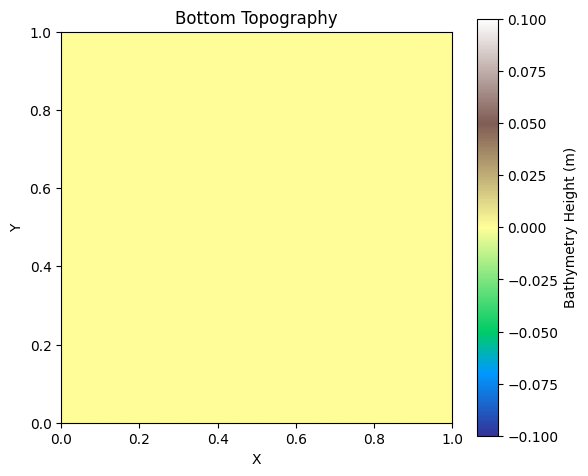

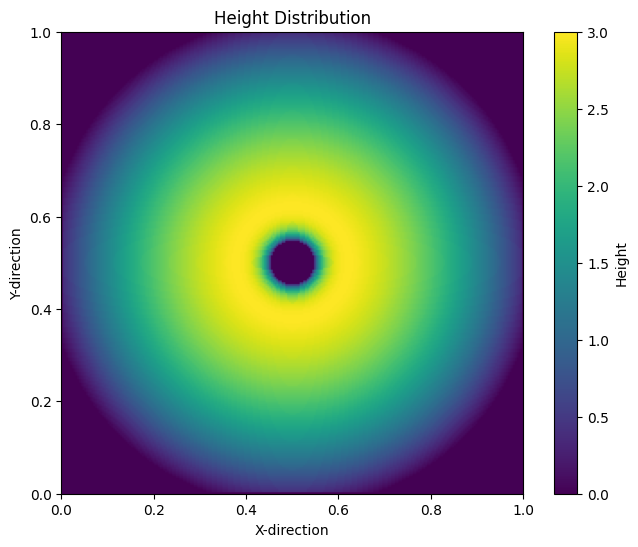

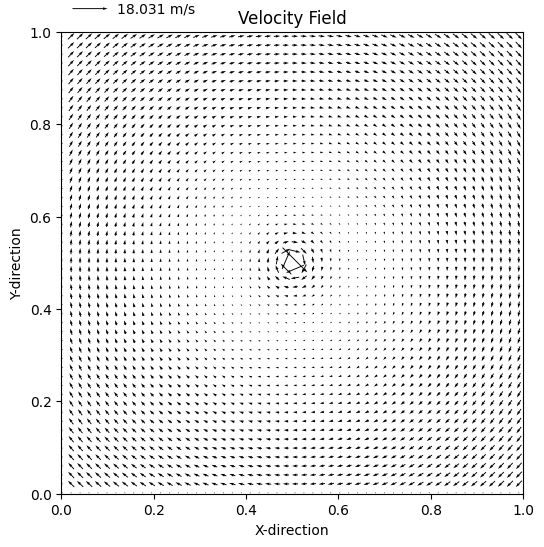

In [221]:
numCellsX = numCellsY = 256
coriolisForce = 10.0  # s^-1
coriolis = np.full_like(height, coriolisForce)

# height, xVelocity, yVelocity = initializeWithRipple(
#     numCellsX, numCellsY,
#     gridXLength, gridYLength,
#     layerDepth,
#     bumpAltitude,
#     bumpWidth,
#     bumpCenterX, bumpCenterY
# )
height, xVelocity, yVelocity = initializeWithVortex(
    numCellsX, numCellsY,
    gridXLength, gridYLength,
    layerDepth,
    0.5, 0.5,
    mode="rankine",
    Omega=-4.0,          # used when mode="solid"  (rad/s in non-dim units)
    Vmax=1.0, Rc=-0.15,  # used when mode="rankine"
    f=coriolis, g=gravity,
    balanced=True
)

# height = np.full((numCellsY+2, numCellsX+2), layerDepth, dtype=np.float64)
# xVelocity = np.zeros((numCellsY+2, numCellsX+2), dtype=np.float64)
# yVelocity = np.zeros((numCellsY+2, numCellsX+2), dtype=np.float64)
# b = make_bathymetry(numCellsX+2, numCellsY+2)
b = np.zeros((numCellsY+2, numCellsX+2), dtype=np.float64)
plot_bathymetry(b, numCellsX+2, numCellsY+2)

# store interior sizes for step_numba
nx = numCellsX
ny = numCellsY

# boundary condition mode (choose what you want)
bc_mode = bc_mode_from_string("periodic")
# bc_mode = bc_mode_from_string("reflective")
# bc_mode = bc_mode_from_string("open")

CFL = 0.4

# estimate timestep the same way, but we should base it on interior values of ghost arrays
maxSpeed = np.maximum(
    np.abs(xVelocity[1:ny+1,1:nx+1]) + fastestSignalSpeed,
    np.abs(yVelocity[1:ny+1,1:nx+1]) + fastestSignalSpeed
).max()

dt  = CFL * min(cellXLength, cellYLength) / maxSpeed
dt0 = CFL * min(cellXLength, cellYLength) / fastestSignalSpeed

nSteps = 2000
outputEvery = 25

# mass: use only interior of ghosted height
startingMass = height[1:ny+1,1:nx+1].sum()

averageNeighborMultiple = 0.001

# momentum helper arrays for diagnostics if you still want them
hu = height[1:ny+1,1:nx+1] * xVelocity[1:ny+1,1:nx+1]
hv = height[1:ny+1,1:nx+1] * yVelocity[1:ny+1,1:nx+1]

t = 0.0
H0 = layerDepth        # e.g. 1.0
waveAmp = 0.02         # keep small
waveFreq = 10.0        # rad/s (tune)
driveCols = 5          # 3-5 is usually stable

fig, ax, img, cbar = init_plot(height, gridXLength, gridYLength)
plotHeight()
plotVelocityField(xVelocity, yVelocity, gridXLength, gridYLength)

Step: 0


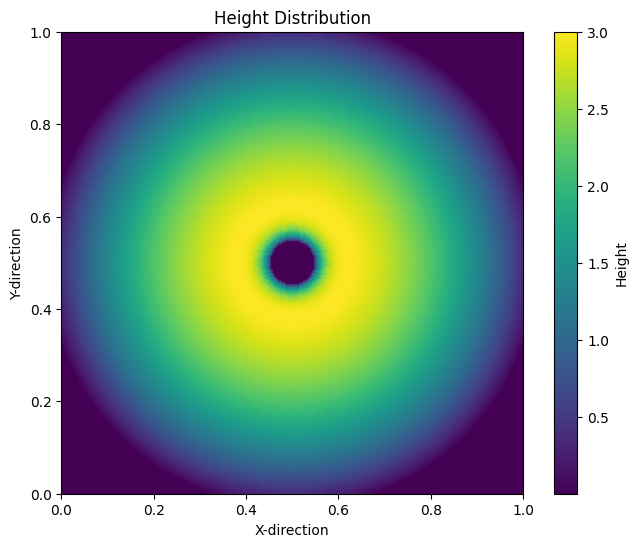

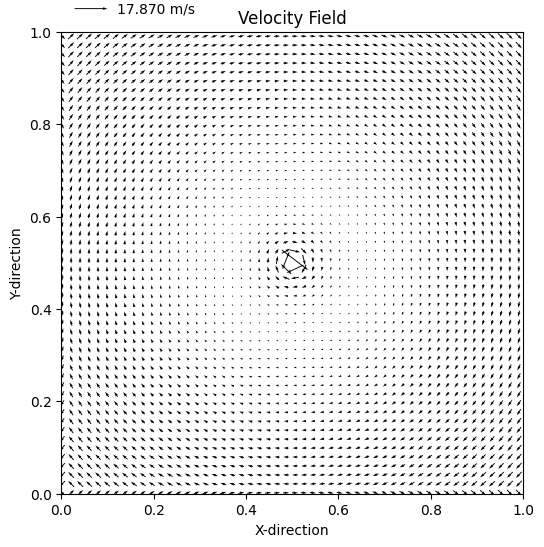

Step: 25


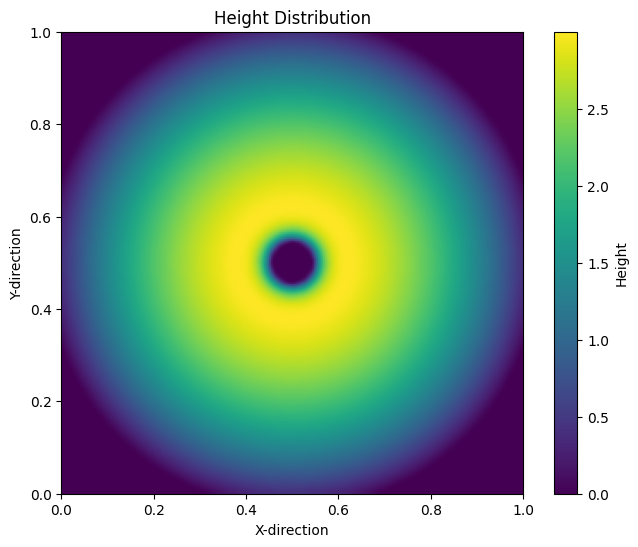

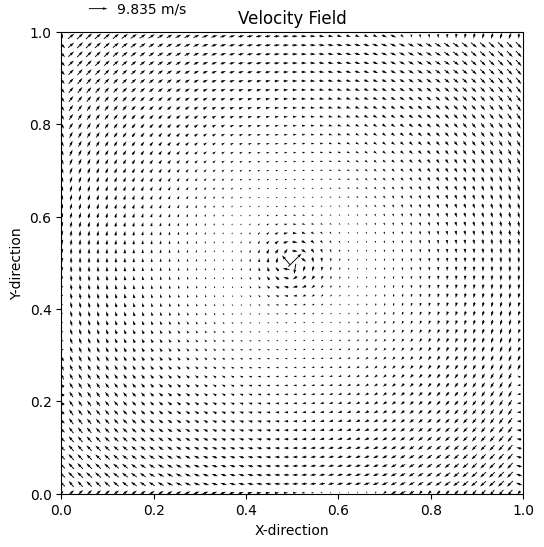

Step: 50


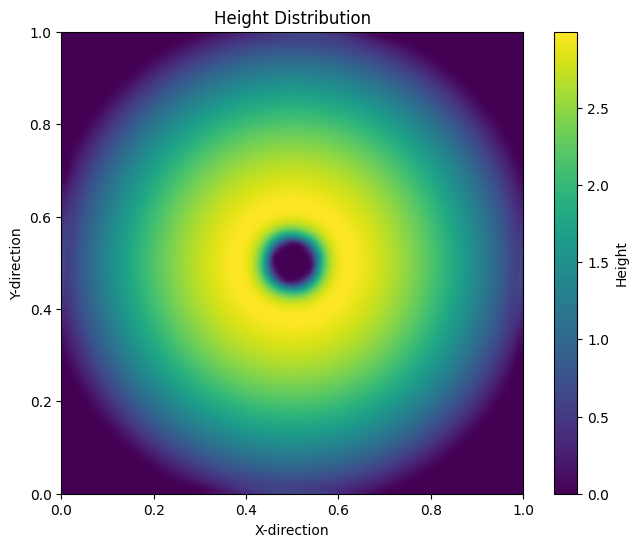

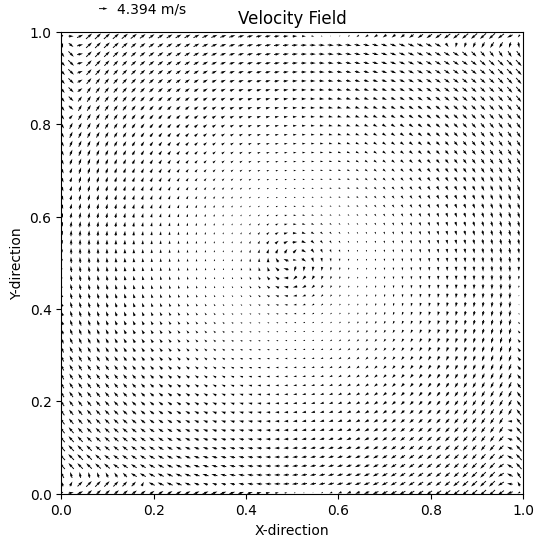

Step: 75


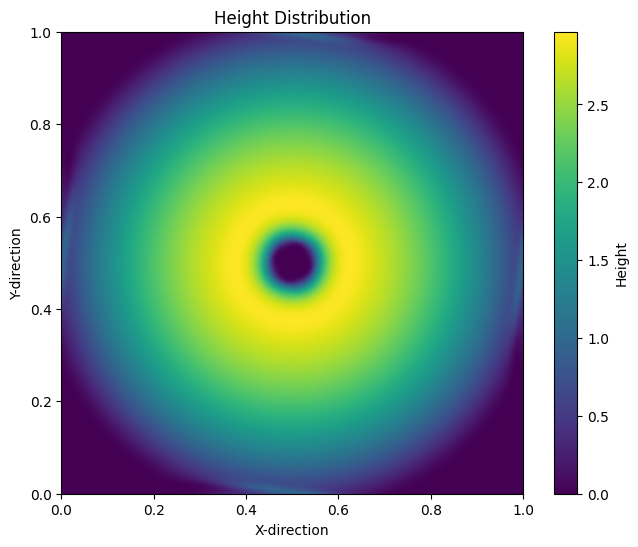

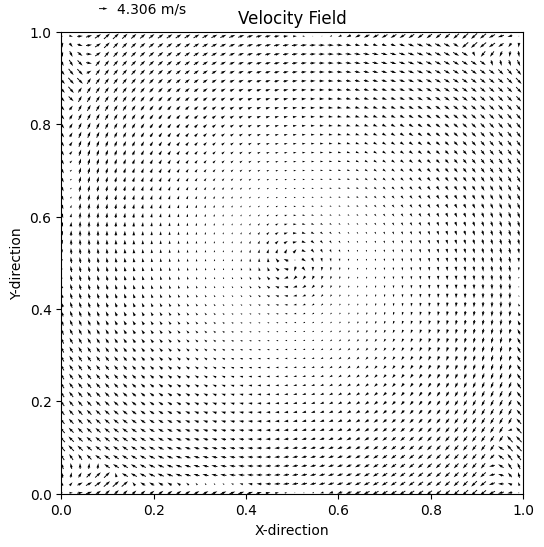

Step: 100


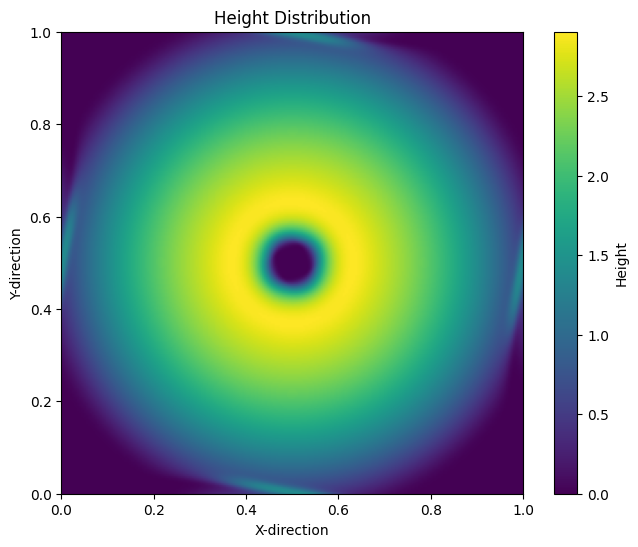

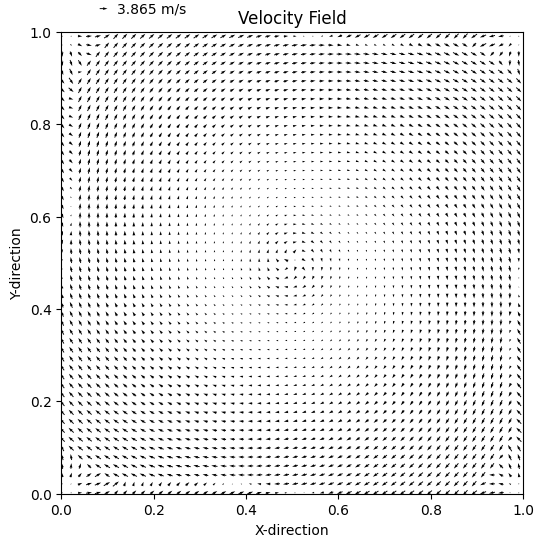

Step: 125


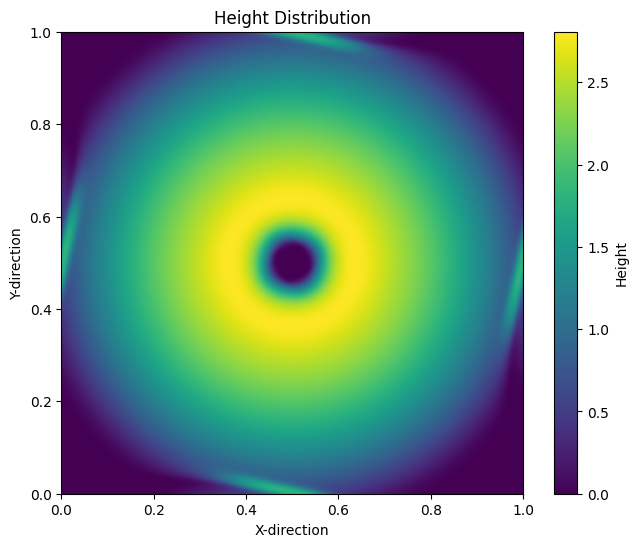

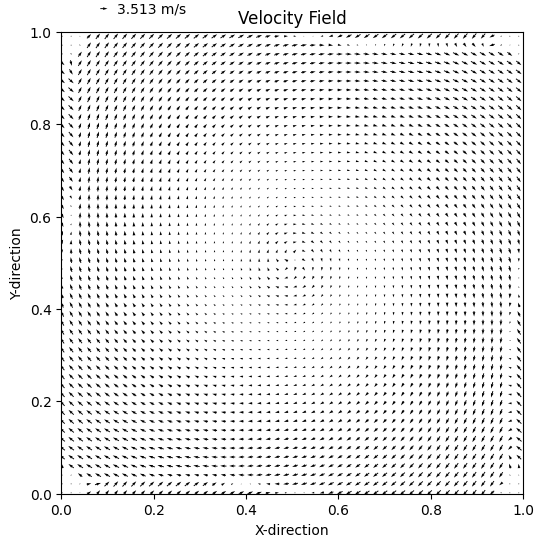

Step: 150


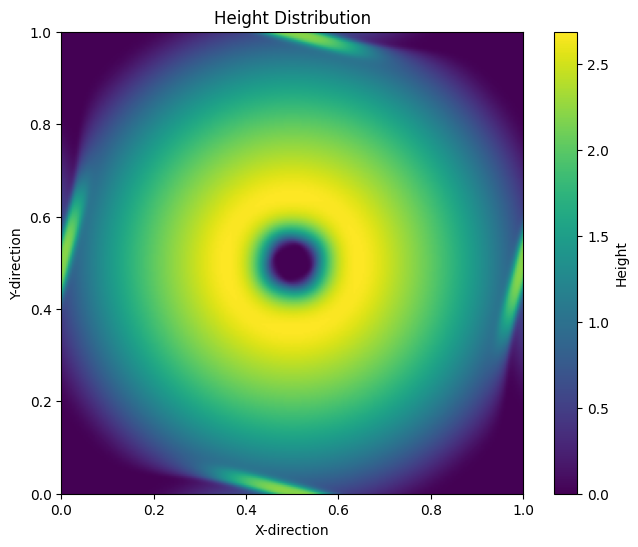

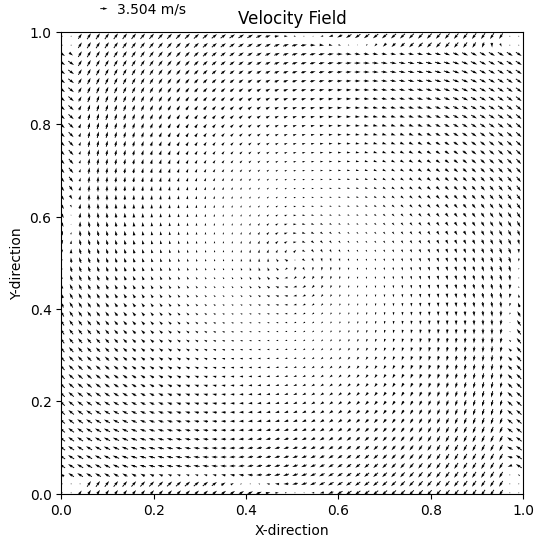

Step: 175


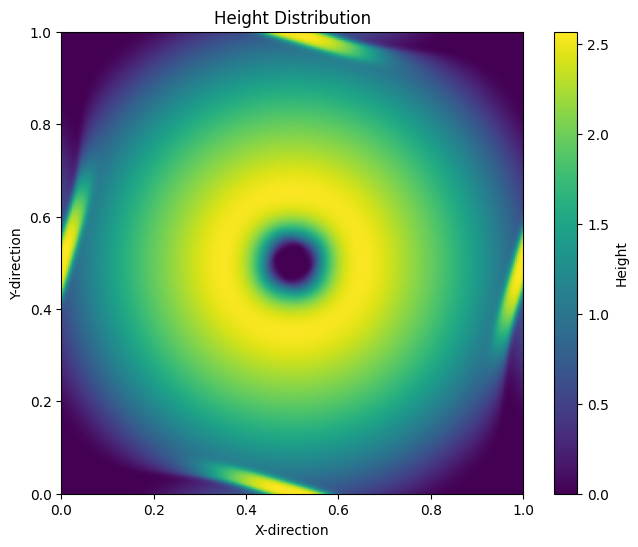

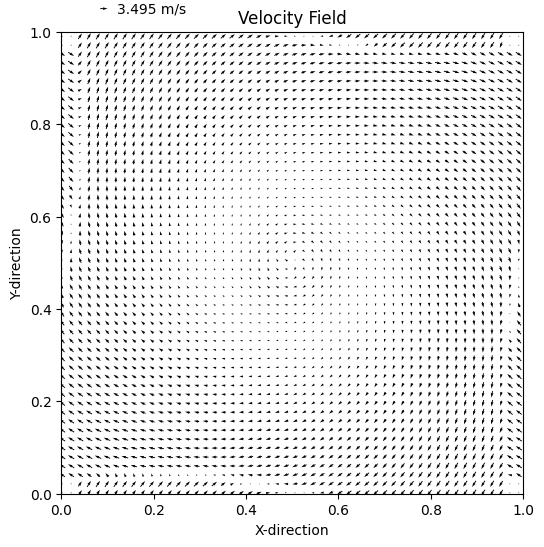

Step: 200


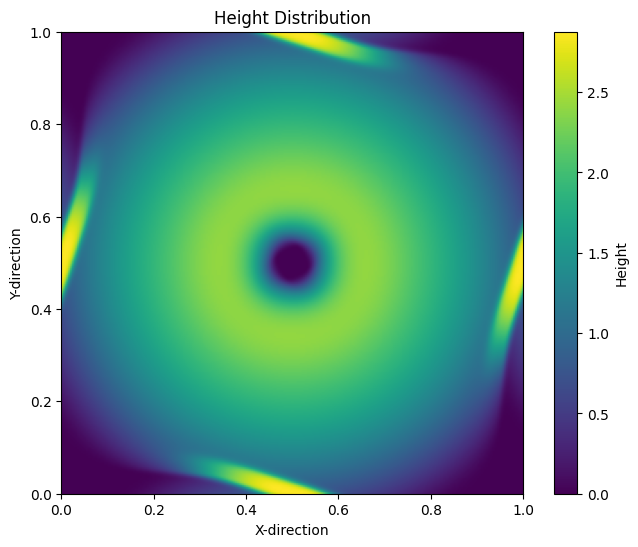

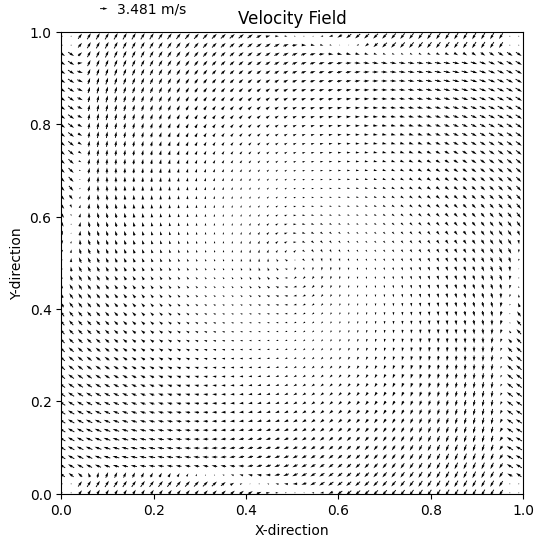

Step: 225


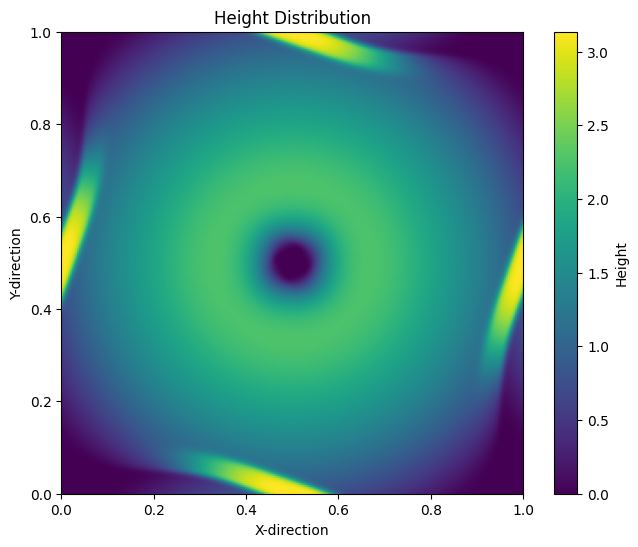

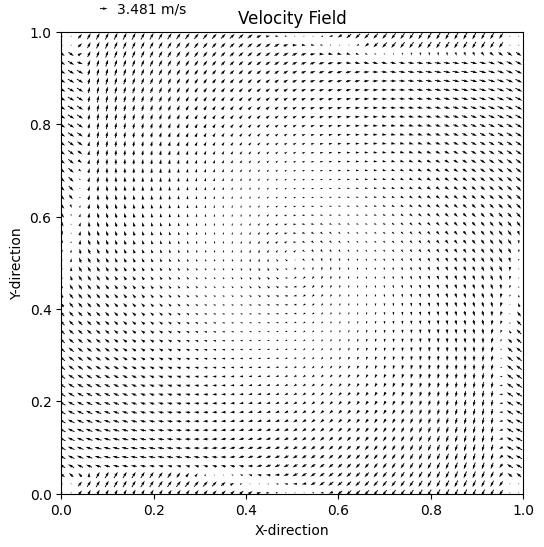

Step: 250


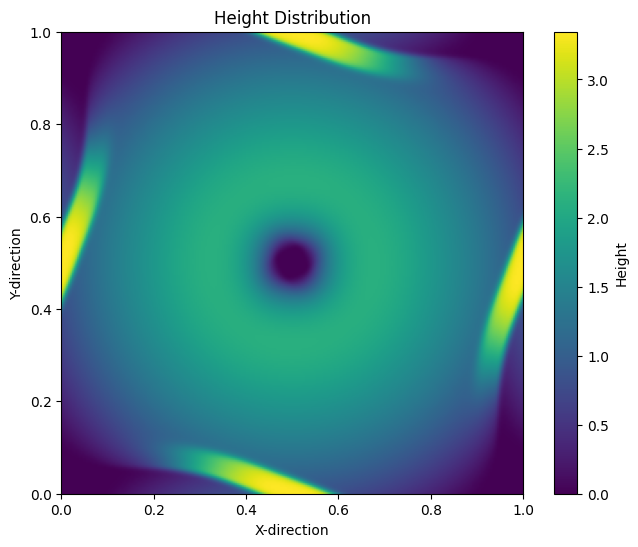

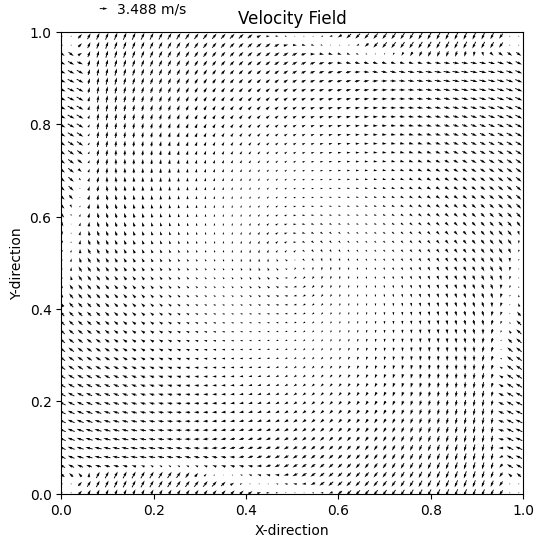

Step: 275


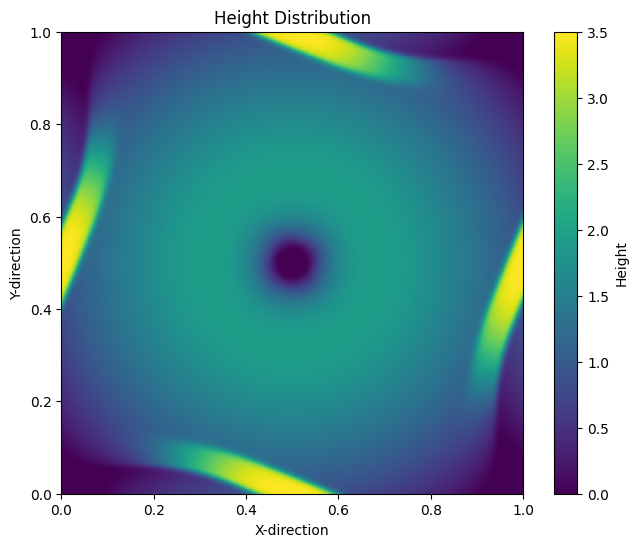

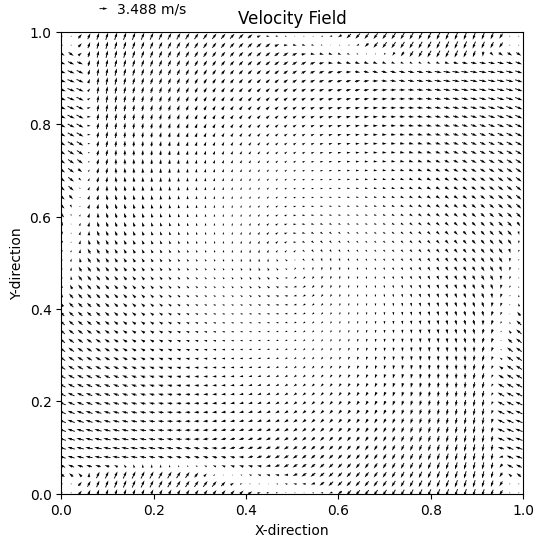

Step: 300


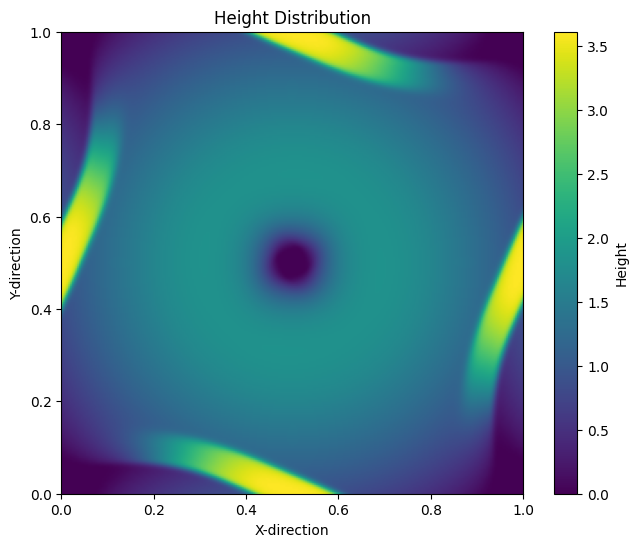

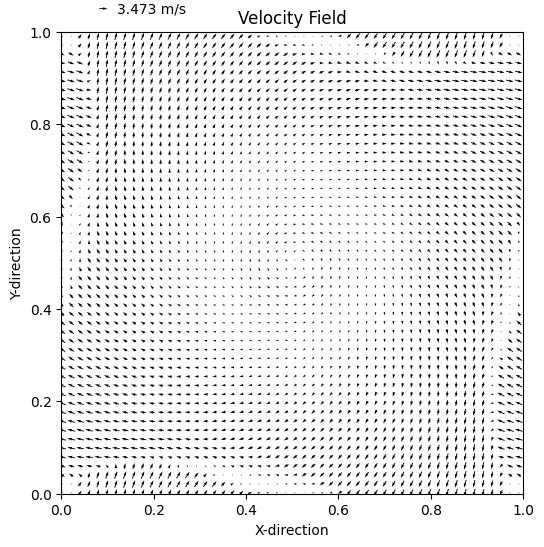

Step: 325


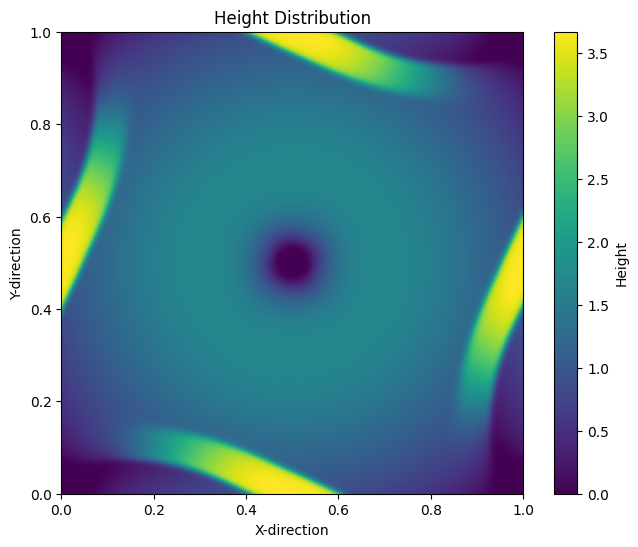

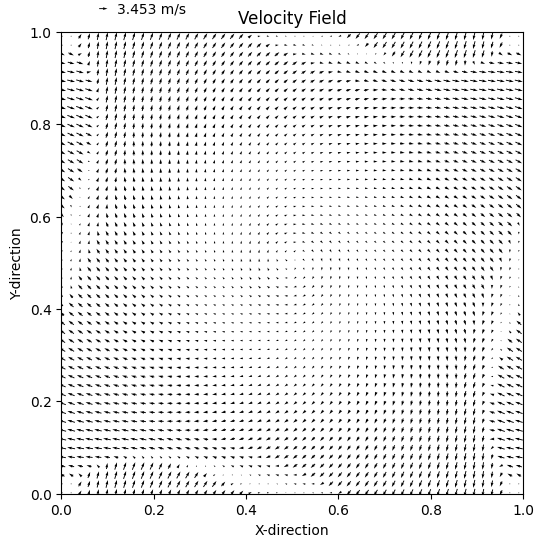

Step: 350


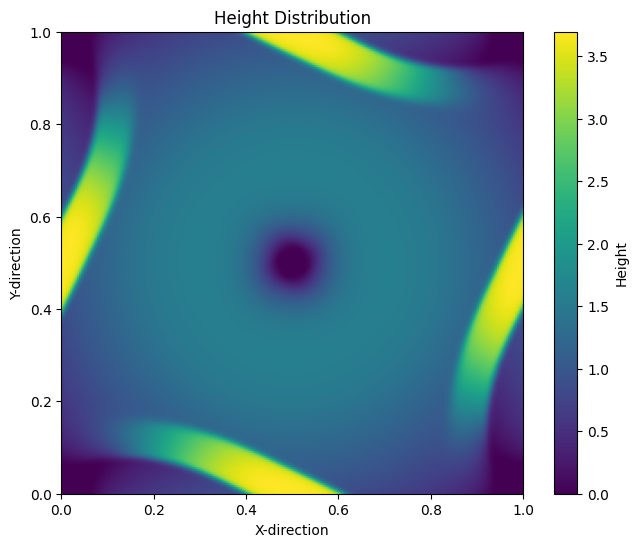

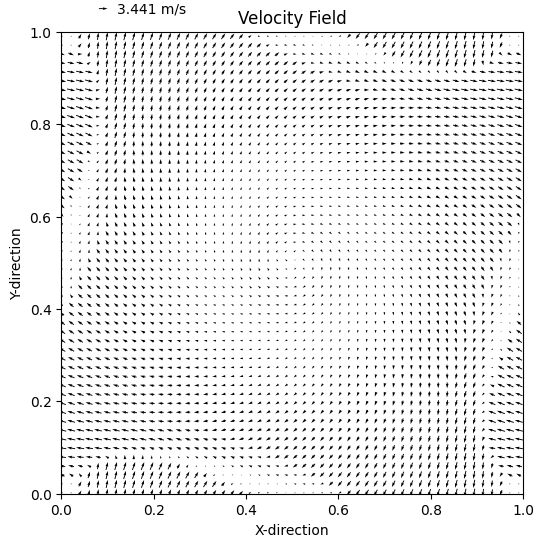

Step: 375


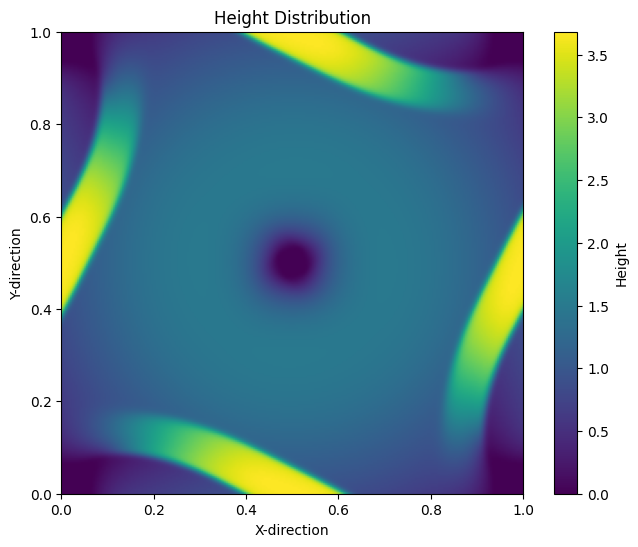

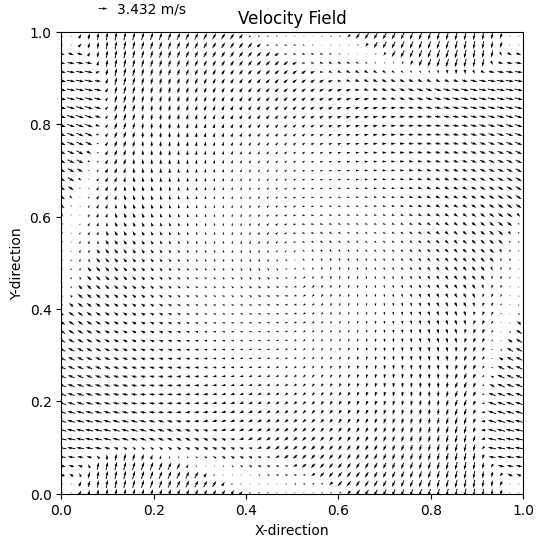

Step: 400


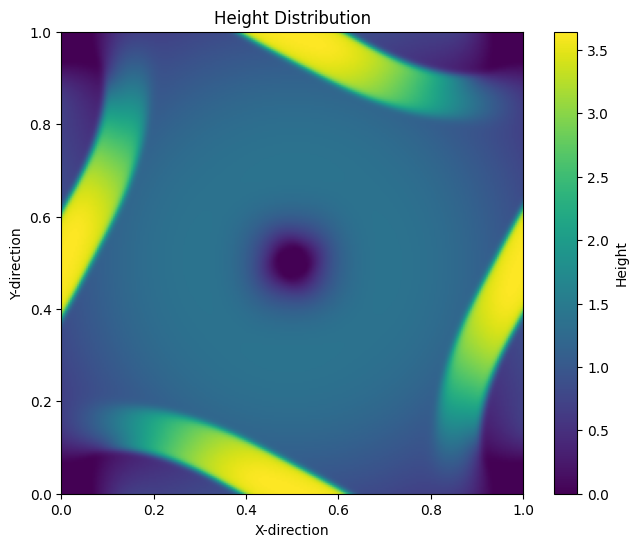

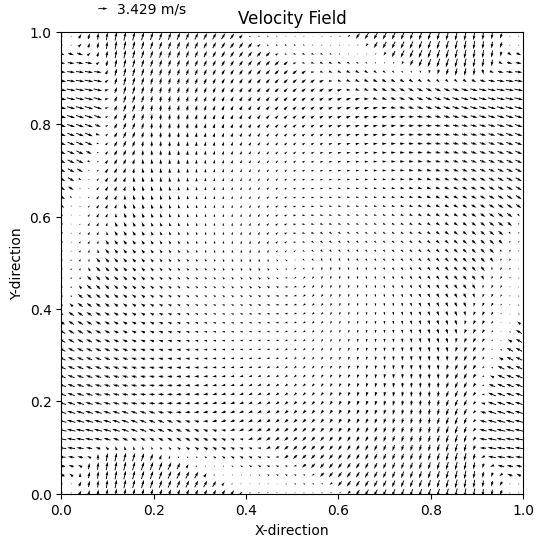

Step: 425


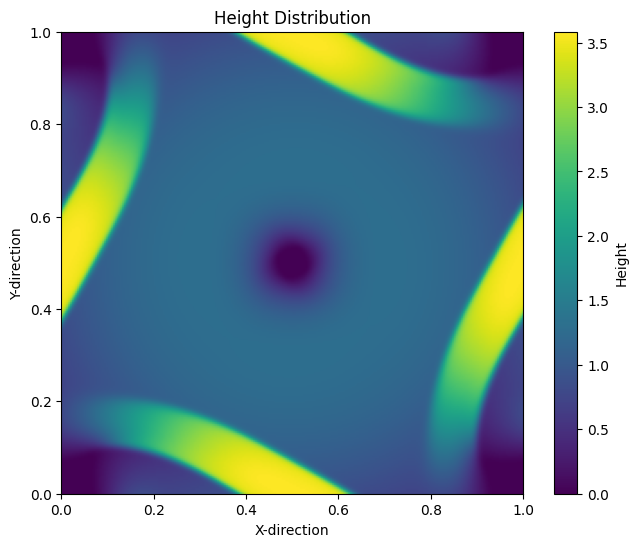

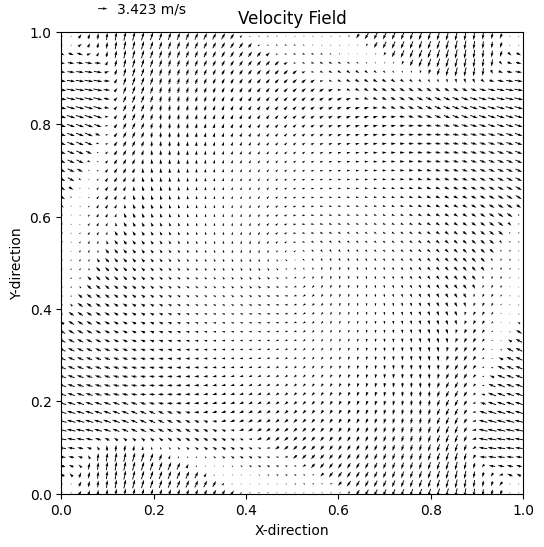

Step: 450


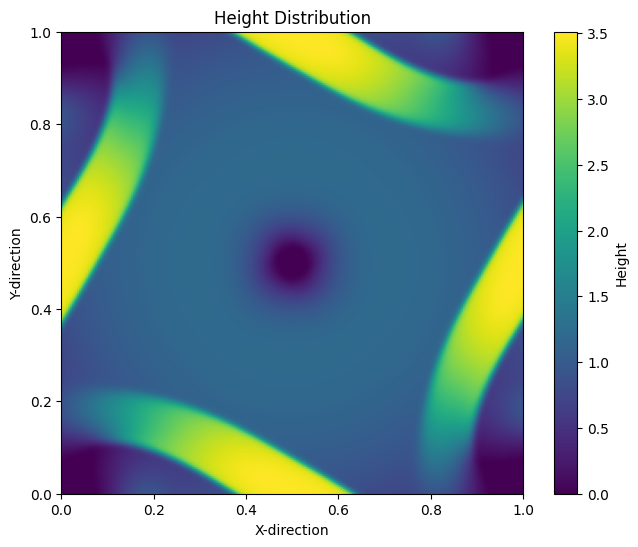

KeyboardInterrupt: 

In [222]:
# xVelocity[:, :] = 0.1
for i in range(nSteps):
    dt = compute_dt(height, xVelocity, yVelocity,
                gravity, CFL, cellXLength, cellYLength,
                coriolis=coriolis, nu=0.0)


    # 2. drive the left boundary (wave maker)
    # drive_left_boundary_height(height,
    #                            xVelocity,
    #                            yVelocity,
    #                            H0,
    #                            waveAmp,
    #                            waveFreq,
    #                            t,
    #                            driveCols)

    height, xVelocity, yVelocity = step_numba(
        height,
        xVelocity,
        yVelocity,
        dt,
        cellXLength,
        cellYLength,
        b,
        coriolis,
        g=gravity,
        nu=0.0,
        h_eps=1e-12,
        nx=nx,
        ny=ny,
        bc_mode=bc_mode
    )

    # saveHeightFrameFast(fig, ax, img, cbar, height, i)

    t += dt

    if i % 25 == 0:
        print(f"Step: {i}")
        plotHeight()
        plotVelocityField(xVelocity, yVelocity, gridXLength, gridYLength)
        # print(np.max(np.abs(xVelocity)), np.max(np.abs(yVelocity)))




In [122]:
filename = 'wavesWithTopography'
!ffmpeg -framerate 60 -i /content/frames/frame_%05d.png -pix_fmt yuv420p {filename}.mp4

from google.colab import files
files.download(f"{filename}.mp4")


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>